# Feature Engineering & Training


In [9]:
#Import packages 
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14.7,7.27)})
sns.set_theme(style="whitegrid")

from config import majors, metrics, feat_cols, target_col
from utils import create_rolling_agg_features_by_golfer, create_map_to_aggregates

import warnings 
warnings.filterwarnings('ignore')

from statsmodels.api import OLS

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import pickle

In [10]:
#Read in the data
scores = pd.read_csv('../data/historical_round_scores.csv')
year = 2021
tourney_name = 'bmw_championship'

pre_tourney = pd.read_csv(f'../data/{year}_{tourney_name}_pre_tourney_snapshot.csv')
pre_tourney.rename(columns={'bet365':'close_odds'}, inplace=True)

In [39]:
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84216 entries, 0 to 84215
Data columns (total 22 columns):
course_name          84216 non-null object
course_num           84216 non-null int64
dg_id                84216 non-null int64
event_completed      84216 non-null object
event_id             84216 non-null int64
event_name           84216 non-null object
fin_text             84216 non-null object
player_name          84216 non-null object
round                84216 non-null object
score                84216 non-null int64
sg_app               66322 non-null float64
sg_arg               66322 non-null float64
sg_ott               66322 non-null float64
sg_putt              66322 non-null float64
sg_t2g               66322 non-null float64
sg_total             84216 non-null float64
year                 84216 non-null int64
close_odds           84216 non-null float64
early_out            84216 non-null int64
fin_num              84216 non-null int64
year_event_id        84216 non-

## Data Processing and Creating new Features

In [11]:
#When did a golfer not finish a full event?
# Cut, Withdrew, Disqualified, etc.
early_outs = ['CUT','DQ','WD', 'W/D', 'MDF',]
early_out_default = 75
scores['early_out'] = np.where(scores.fin_text.isin(early_outs), 1, 0)

#Cleaning up where a golfer finished a tournament
#Making it numeric for use in the model
scores['fin_num'] = (np.where(scores.fin_text.isin(early_outs),
                             early_out_default,
                             scores.fin_text.str.replace('T',''))
                    ).astype(int)

#Replacing Early Out Finishes with the Max finishing position per event
scores['year_event_id'] = scores['year'].astype(str) + '_' + scores['event_id'].astype(str)
max_fin_dict = create_map_to_aggregates(scores, 'year_event_id', 'fin_num', 'max')
scores['fin_num'] = np.where(scores.fin_text.isin(early_outs),
                             scores.year_event_id.map(max_fin_dict),
                             scores.fin_num)

#Filling in NULL close odds with avg per golfer
mean_close_odds_per_golfer_dict = create_map_to_aggregates(scores, 'dg_id', 'close_odds', 'mean')
scores['close_odds'] = np.where(pd.isnull(scores.close_odds),
                                 scores.dg_id.map(mean_close_odds_per_golfer_dict),
                                scores.close_odds)

scores['close_odds'] = scores['close_odds'].fillna(scores.close_odds.quantile(.75))

In [12]:
#Creating a unique year/event/golfer identifier
scores['year_event_golfer'] = (scores['year'].astype(str) +
                                      '_' + scores['event_id'].astype(str) +
                                      '_' + scores['dg_id'].astype(str)
                              )

# Aggregating round data to an event level
event_df = (scores.groupby(['dg_id','player_name','event_name',
                            'event_id','fin_text','fin_num','early_out','close_odds',
                            'year','year_event_id','year_event_golfer','event_completed',]).
            agg(rounds=('round','count'),
                mean_score = ('score', 'mean'),
                mean_sg = ('sg_total', 'mean'),
                total_sg = ('sg_total', 'sum')
               ).reset_index().sort_values('event_completed')
           )

#Was the event a major?
event_df['major'] = np.where(event_df['event_name'].isin(majors), 1, 0)

#Did the golfer win the major?
event_df['won_major'] = np.where((event_df['major'] == 1) & (event_df.fin_num == 1), 1, 0)

#Did the golfer finish in the top 10?
event_df['top_10'] = np.where(event_df['fin_num'] <= 10, 1, 0)

In [13]:
#For each desired metric, period combination
#Calculate the rolling aggregation prior to a given event for each golfer
#Add the calculated series to the event dataset as a new column
for metric in metrics:
    field = metric.get('field')
    agg = metric.get('agg')
    for period in metric.get('periods'):
        col = f"{field}_in_prev_{period}_events"
        event_df[col] = create_rolling_agg_features_by_golfer(event_df, field, 1, period, agg)
        
#filtering out events with no odds data
event_df = event_df.loc[event_df.close_odds != -1]

## Exploratory Data Analysis
Inspecting the data and creating visuals to get a better understanding

In [14]:
events_in_dataset = len(event_df.year_event_id.unique())
majors_in_dataset = len(event_df.query("major == 1").year_event_id.unique())
first_event_complete = event_df.event_completed.min()
last_event_complete = event_df.event_completed.max()
unique_golfers = len(event_df.dg_id.unique())

print(f'There are {events_in_dataset} events in the dataset')
print(f'{majors_in_dataset} of which are majors')
print(f'Events span from {first_event_complete} to {last_event_complete}')
print(f'A total of {unique_golfers} golfers have played in these events')

There are 213 events in the dataset
19 of which are majors
Events span from 2017-01-08 to 2021-08-22
A total of 1270 golfers have played in these events


Taking a look at Strokes Gained

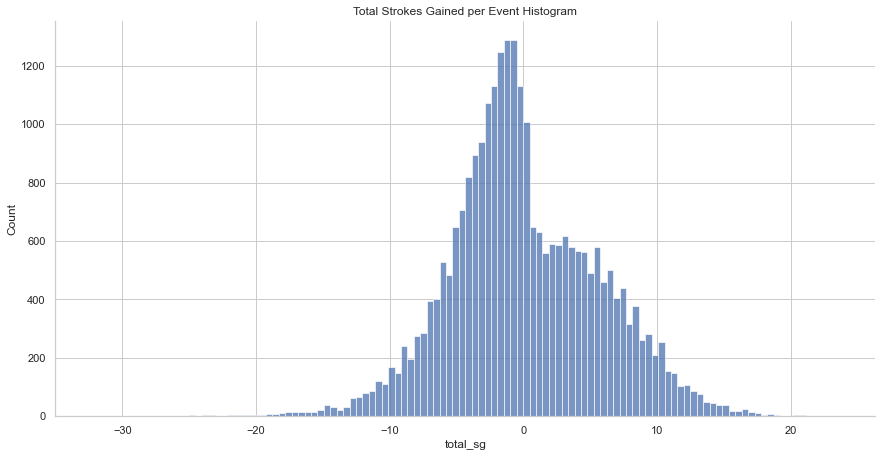

In [15]:
sns.histplot(data=event_df, x="total_sg")
plt.title('Total Strokes Gained per Event Histogram')
sns.despine();

Somewhat normally distributed and centered around 0.

Looking at Scoring by whether it's a major or not.

In [16]:
#Grouping and aggregating strokes gained and events played by golfer
golfer_sg = (event_df.groupby(['dg_id','player_name'])
             .agg(total_sg = ('total_sg', 'sum'),
                  events_played =('year_event_id', 'count')
                 )
            ).reset_index()

#Creating strokes gained per event field
golfer_sg['sg_per_event'] = golfer_sg['total_sg'] / golfer_sg['events_played']

#Top 5 golfers by strokes gained per event
#With at least 10 events played
(golfer_sg.query("events_played >= 10")
 .sort_values('sg_per_event', ascending = False)
 .head()
 .reset_index(drop=True)
)

,dg_id,player_name,total_sg,events_played,sg_per_event
0,19195,"Rahm, Jon",592.113,91,6.506736
1,12422,"Johnson, Dustin",542.680,90,6.029778
2,14139,"Thomas, Justin",619.453,103,6.014107
3,10091,"McIlroy, Rory",487.017,82,5.939232
4,15466,"Cantlay, Patrick",450.182,87,5.174506


In [17]:
#Bottom 5golfers by strokes gained per event
#With at least 10 events played
(golfer_sg.query("events_played >= 10")
 .sort_values('sg_per_event')
 .head()
 .reset_index(drop=True)
)

,dg_id,player_name,total_sg,events_played,sg_per_event
0,8263,"Perry, Rod",-102.379,10,-10.237900
1,4761,"Duval, David",-124.549,13,-9.580692
2,23853,"Beach, Alex",-78.571,10,-7.857100
3,5906,"Purdy, Ted",-97.872,14,-6.990857
4,863,"Daly, John",-130.817,19,-6.885105


Taking a look at whether strokes gained varies with a major

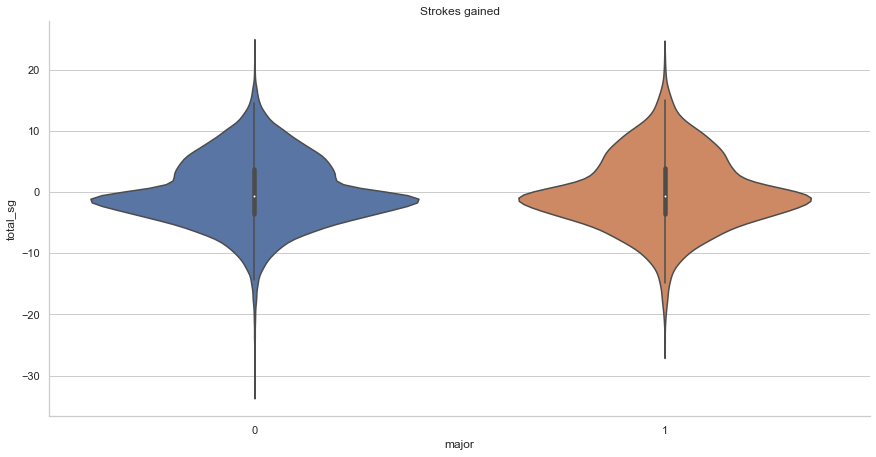

In [18]:
sns.violinplot(data = event_df, x = 'major', y='total_sg')\
.set_title('Strokes gained')
sns.despine();

Makes sense that the answer is **No** since strokes gained is a relative metric based on the event

Taking a look at correlations...

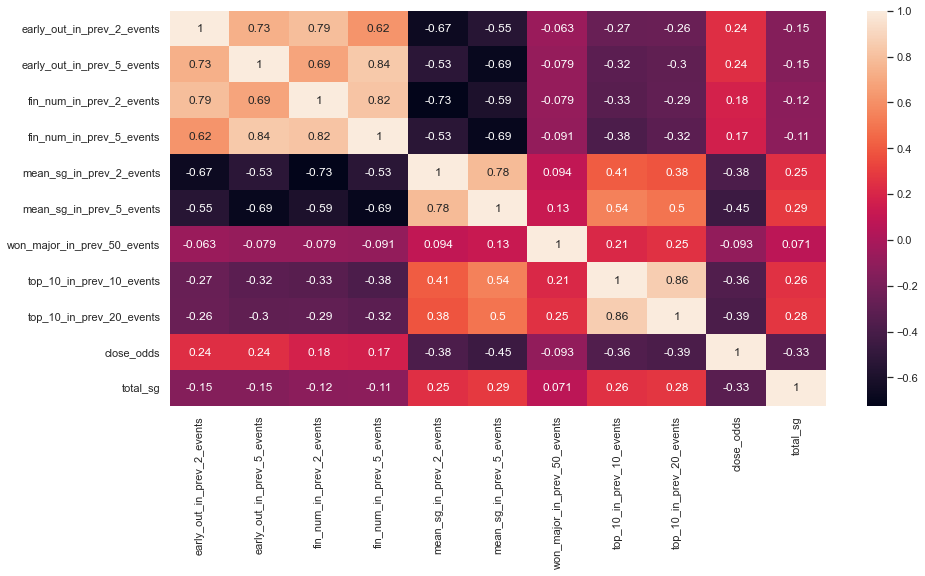

In [19]:
c = event_df[feat_cols + [target_col]].corr()
sns.heatmap(c, annot=True);

It does appear that many of the lagging aggregate feature have correlations that are low to mid in strength.

Close odds also has a pretty strong negative correlation at **-0.35**.

## Training

In [20]:
#Filtering out the first 10 events of the dataset
#This is necessary because of the lag features
early_events_to_filter = event_df.sort_values('event_completed')['year_event_id'].unique()[0:11]
event_df = (event_df.loc[~event_df.year_event_id.isin(early_events_to_filter)]
            .reset_index(drop=True))

#splitting the data into independent (X) and dependent variables(y)
X = event_df[feat_cols]

y = event_df['total_sg']

### Fitting a Linear Regression Model

In [21]:
#Fitting the model on the feature and target data
lr = OLS(y, X).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:               total_sg   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     451.6
Date:                Thu, 26 Aug 2021   Prob (F-statistic):               0.00
Time:                        12:54:12   Log-Likelihood:                -78565.
No. Observations:               25611   AIC:                         1.571e+05
Df Residuals:                   25601   BIC:                         1.572e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
early_out_in_prev_

#### Checking assumptions for a linear model:
    1. Must be linear in nature
    2. Residuals are normally distributed
    3. No Multicollinearity between predictors

Assumption 1: Linear Relationship between the Target and the Feature 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


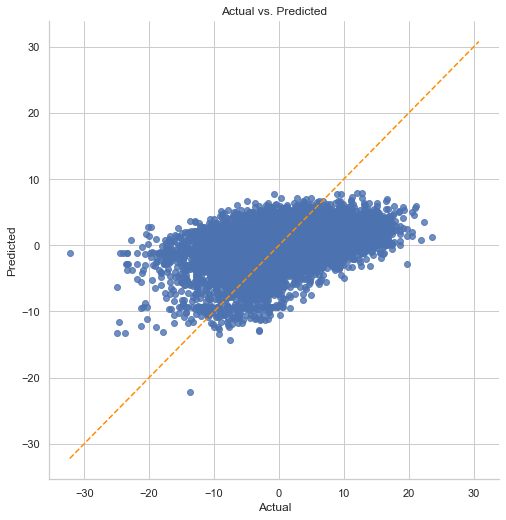

In [30]:
def calculate_residuals(model, features, label):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])
    
    return df_results

def linear_assumption(model, features, label):
    """
    Linearity: Assumes that there is a linear relationship between the predictors and
               the response variable.
    """
    print('Assumption 1: Linear Relationship between the Target and the Feature', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = calculate_residuals(model, features, label)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
    # Plotting the diagonal line
    line_coords = np.arange(df_results.min().min(), df_results.max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()
    
linear_assumption(lr, X, y);

There is far from a perfect linear relationship here

Assumption 2: The error terms are normally distributed 

p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


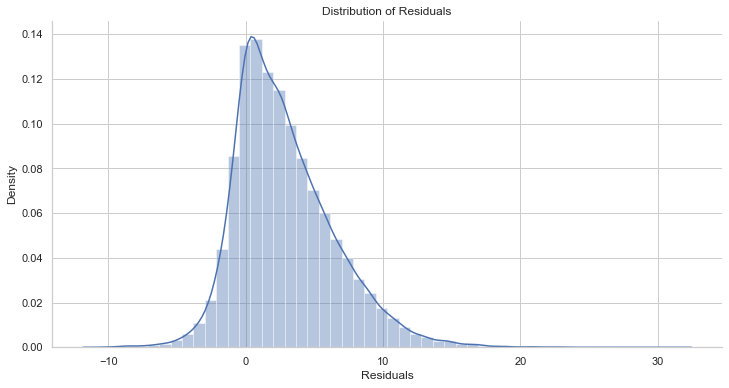


Assumption not satisfied


In [23]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    """
    Normality: Assumes that the error terms are normally distributed. If they are not,
    nonlinear transformations of variables may solve this.
               
    This assumption being violated primarily causes issues with the confidence intervals
    """
    from statsmodels.stats.diagnostic import normal_ad
    print('Assumption 2: The error terms are normally distributed', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = calculate_residuals(model, features, label)

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.subplots(figsize=(12, 6))
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    sns.despine()
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Assumption satisfied')
    else:
        print('Assumption not satisfied')
        
normal_errors_assumption(lr, X, y, p_value_thresh=0.05)

In [38]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    """
    Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                       correlation among the predictors, then either remove prepdictors with high
                       Variance Inflation Factor (VIF) values or perform dimensionality reduction
                           
                       This assumption being violated causes issues with interpretability of the 
                       coefficients and the standard errors of the coefficients.
    """
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    print('Assumption 3: Little to no multicollinearity among predictors')
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [round(variance_inflation_factor(features.values, i),1) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Assumption satisfied')
        else:
            print('Assumption possibly satisfied')
            print()
            print('Coefficient interpretability may be problematic')

    else:
        print('Assumption not satisfied')
        print()
        print('Coefficient interpretability will be problematic')
        
        
multicollinearity_assumption(lr, X, y, feature_names=X.columns)

Assumption 3: Little to no multicollinearity among predictors
Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
early_out_in_prev_2_events: 10.7
early_out_in_prev_5_events: 17.8
fin_num_in_prev_2_events: 61.8
fin_num_in_prev_5_events: 68.9
mean_sg_in_prev_2_events: 6.5
mean_sg_in_prev_5_events: 6.6
won_major_in_prev_50_events: 1.1
top_10_in_prev_10_events: 6.2
top_10_in_prev_20_events: 6.6
close_odds: 2.0

4 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption possibly satisfied

Coefficient interpretability may be problematic


## Fitting a Random Forest
Since the linear regression assumptions were not satisfied, moving on to a less demanding model

In [25]:
#Instantiate a Random Forest for Regression
rf = RandomForestRegressor(n_estimators=300, min_samples_split=4, max_depth=10)

#Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 42)

#Fit the model
rf.fit(X_train, y_train)

#Make a prediction on the test data
preds = rf.predict(X_test)

mae = mean_absolute_error(y_test, preds).round(3)
print(f'Mean absolute error of {mae}')

Mean absolute error of 3.999


In [26]:
feat_imp_df = (pd.DataFrame({'feature': X_train.columns, 'importance': rf.feature_importances_})
               .sort_values('importance', ascending=False)
              )

In [27]:
feat_imp_df

,feature,importance
9,close_odds,0.568324
5,mean_sg_in_prev_5_events,0.121357
4,mean_sg_in_prev_2_events,0.094559
3,fin_num_in_prev_5_events,0.094548
2,fin_num_in_prev_2_events,0.063824
8,top_10_in_prev_20_events,0.023515
1,early_out_in_prev_5_events,0.014045
7,top_10_in_prev_10_events,0.012874
0,early_out_in_prev_2_events,0.003752
6,won_major_in_prev_50_events,0.003203


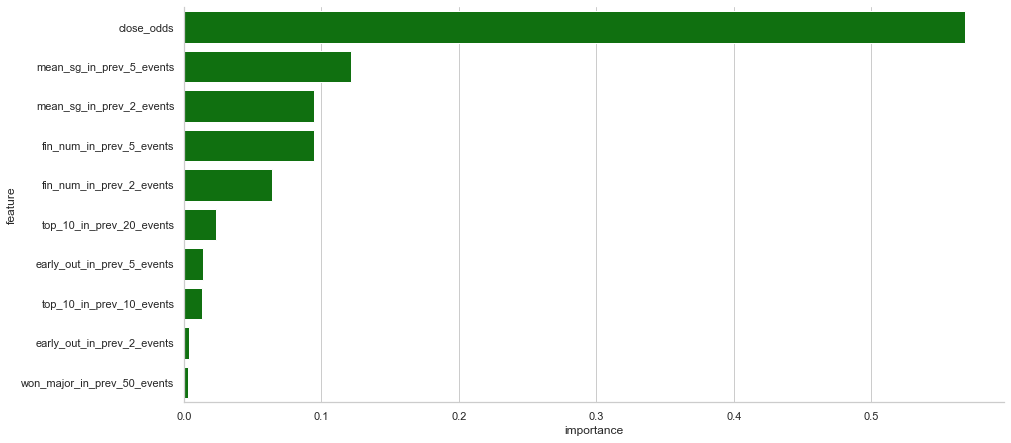

In [29]:
sns.barplot(x ='importance', y='feature', data=feat_imp_df, color='green')
sns.despine();

In [ ]:
#Save the RF model
pickle.dump(rf, open("../models/rf_model.pkl", "wb"))

#Write the event file for prediction on new data
event_df.to_csv('../data/historical_event_data.csv', index=False)